# PREDICTING SEPSIS RISK DURING IN-PATIENT ADMISSIONS
*Client: Royal Perth Hospital*

*Team: Group 7*

# Readme
The following libraries need to be installed in order to run the source code.

In [1]:
import pandas as pd
import numpy as np, warnings
from pathlib import Path
import os
import sweetviz as sv
from importlib import reload

os.chdir('D:/Kha/UWA/CITS5553/sepsis_prediction/data-science-capstone-project/Kha Huynh')
import my_util
reload(my_util)

np.warnings = warnings
os.chdir('D:/Kha/UWA/CITS5553/sepsis_prediction/data-science-capstone-project')

# 1.Dataset Processing

## 1.1 Data Cleaning

Load the dataset. The following tables are loaded for this project:
- PATIENTS
- ADMISSIONS
- DIAGNOSES_ICD
- LABEVENTS
- MICROBIOLOGYEVENTS
- D_ICD_DIAGNOSES
- D_ITEMS

In [2]:
# load transaction dataset
df_patients = pd.read_csv('data\PATIENTS.csv')
df_admissions = pd.read_csv('data\ADMISSIONS.csv')
df_diagnoses_icd = pd.read_csv('data\DIAGNOSES_ICD.csv')
df_labevents = pd.read_csv('data\LABEVENTS.csv')
df_microbiologyevents = pd.read_csv('data\MICROBIOLOGYEVENTS.csv')

# load description tables
df_desc_icd = pd.read_csv('data\D_ICD_DIAGNOSES.csv')
df_desc_labitems = pd.read_csv('data\D_LABITEMS.csv')
df_desc_items = pd.read_csv('data\D_ITEMS.csv')

In [2]:
df_labevents = pd.read_csv('data\LABEVENTS.csv')
df_desc_labitems = pd.read_csv('data\D_LABITEMS.csv')
df_labevents_processed = df_labevents.drop_duplicates(subset=['SUBJECT_ID', 'HADM_ID', 'CHARTTIME'], ignore_index=True)[['SUBJECT_ID', 'HADM_ID', 'CHARTTIME']]
df_labevents_processed = df_labevents.drop_duplicates(subset=['SUBJECT_ID', 'HADM_ID', 'CHARTTIME'], ignore_index=True)[['SUBJECT_ID', 'HADM_ID', 'CHARTTIME']]

In [3]:
# Convert the following datetime columns to datetime format
# patients: DOB to date format, we not care about the birth time
df_patients['DOB'] = pd.to_datetime(df_patients['DOB'], format='%Y-%m-%d %H:%M:%S')
# admissions: ADMITTIME, DISCHTIME, EDREGTIME, EDOUTTIME
df_admissions['ADMITTIME'] = pd.to_datetime(df_admissions['ADMITTIME'], format='%Y-%m-%d %H:%M:%S')
df_admissions['DISCHTIME'] = pd.to_datetime(df_admissions['DISCHTIME'], format='%Y-%m-%d %H:%M:%S')
df_admissions['EDREGTIME'] = pd.to_datetime(df_admissions['EDREGTIME'], format='%Y-%m-%d %H:%M:%S')
df_admissions['EDOUTTIME'] = pd.to_datetime(df_admissions['EDOUTTIME'], format='%Y-%m-%d %H:%M:%S')
# labevents: CHARTTIME
df_labevents['CHARTTIME'] = pd.to_datetime(df_labevents['CHARTTIME'], format='%Y-%m-%d %H:%M:%S')
# microbiologyevents: CHARTDATE to date format and CHARTTIME to datetime format
df_microbiologyevents['CHARTDATE'] = pd.to_datetime(df_microbiologyevents['CHARTDATE'], format='%Y-%m-%d')
df_microbiologyevents['CHARTTIME'] = pd.to_datetime(df_microbiologyevents['CHARTTIME'], format='%Y-%m-%d %H:%M:%S')

The DIAGNOSES_ICD tables has a column ICD9_CODE which is the code for each disease diagnosed for the patient.

The Sepsis has 6 codes: ['77181', '99591', '99592', '67020', '67022', '67024']

We'll introduce a new column, IS_SEPSIS, as a binary classifier (1 for 6 sepsis ICD9 codes, 0 otherwise) for the target variable.

In [4]:
# retrieve all sepsis icd code
sepsis_icd =  df_desc_icd[df_desc_icd.apply(lambda x:'seps' in x['SHORT_TITLE'].lower(),axis=1)]['ICD9_CODE'].values
# add new binary classifier target variable
df_diagnoses_icd['IS_SEPSIS'] = df_diagnoses_icd.apply(lambda x: 1 if x['ICD9_CODE'] in sepsis_icd else 0, axis=1)

In [5]:
try:
    df_demographic = pd.read_csv('data\demographic.csv')
except:
    # merge the patients and admission tables to a demographic dataframe
    df_demographic = pd.merge(df_admissions, df_patients[['SUBJECT_ID', 'GENDER', 'DOB', 'EXPIRE_FLAG']], on='SUBJECT_ID')
    # create an age column to each case
    df_demographic['AGE'] = ((df_demographic['ADMITTIME'].dt.date - df_demographic['DOB'].dt.date) // 365).dt.days
    # add column IS_SEPSIS to demographic data indicating which case is diagnosed with sepsis
    df_demographic['IS_SEPSIS'] = df_demographic.apply(lambda x: my_util.check_sepsis(x['SUBJECT_ID'], x['HADM_ID'], df_diagnoses_icd), axis=1)
    my_util.save_csv(df_demographic, 'data\demographic.csv')

there are 5406 admissions has IS_SEPSIS=1.

But in the df_diagnoses_icd has 5409. The code below found that 3 HADM_ID is diagnosed sespsis 2 twice (with the same/different sepsis icd9_code)

In [ ]:
# there are 3 HADM_ID are predicted sepsis twice in diagnoses table
df_diagnoses_icd[df_diagnoses_icd['IS_SEPSIS'] == 1]['HADM_ID'][df_diagnoses_icd[df_diagnoses_icd['IS_SEPSIS'] == 1]['HADM_ID'].duplicated()]

#### Unpivot the labevents table - due to memory crash, this code cannot be executed

In [71]:
# no need to run this
df_labevents_processed = df_labevents.drop_duplicates(subset=['SUBJECT_ID', 'HADM_ID', 'CHARTTIME'], ignore_index=True)[['SUBJECT_ID', 'HADM_ID', 'CHARTTIME']]
my_util.save_csv(df_labevents_processed, 'data\output_csv\df_labevents_processed.csv')

In [10]:
df_labevents_processed = pd.read_csv("data\output_csv\df_labevents_processed.csv")
df_labevents_processed['CHARTTIME'] = pd.to_datetime(df_labevents_processed['CHARTTIME'], format='%Y-%m-%d %H:%M:%S')
df_labevents_processed['HADM_ID'] = df_labevents_processed['HADM_ID'].astype('Int64')

In [12]:
# no need to run this code
df_labevents_processed = my_util.create_labevent_columns(df_labevents_processed, df_desc_labitems[:300]['ITEMID'])
my_util.save_csv(df_labevents_processed, 'data\output_csv\df_labevents_processed_51346_50972.csv')

In [ ]:
# no need to run this code
df_labevents_processed = my_util.create_labevent_columns(df_labevents_processed, df_desc_labitems[300:]['ITEMID'])
my_util.save_csv(df_labevents_processed, 'data\output_csv\df_labevents_processed_50973_51555.csv')

In [ ]:
def add_column(df_labevents_processed, data):
    for i, x in data.iterrows():
        subject_id = x['SUBJECT_ID']
        hadm_id = x['HADM_ID']
        charttime = x['CHARTTIME']
        item_id = x['ITEM_ID']
        flag = x['FLAG']
        value = x['VALUE']
        r_index = df_labevents_processed[(df_labevents_processed.SUBJECT_ID == subject_id) & (df_labevents_processed.HADM_ID==hadm_id) &
         (df_labevents_processed.CHARTTIME==charttime)].index
        df_labevents_processed.at[r_index, item_id] = value
        df_labevents_processed.at[r_index, f"{item_id}_FLAG"] = flag

add_column(df_labevents_processed, df_labevents[:20])

#### Next we inspect the tables to see any unexpected points

Plotting the boxplot of age between admissions sepsis and non-sepsis below found that older people is likely to have sepsis than the young.

<Axes: title={'center': 'AGE'}, xlabel='IS_SEPSIS'>

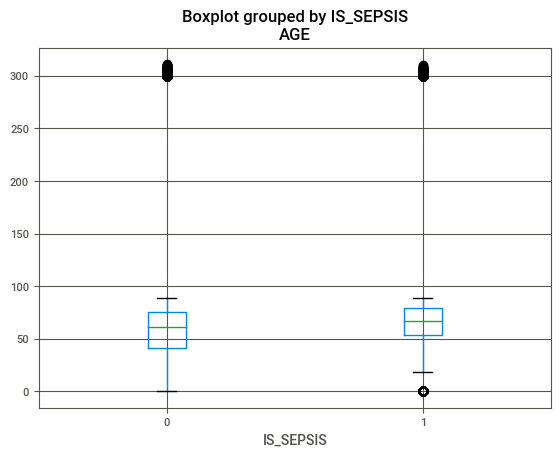

In [65]:
df_demographic.boxplot(column=['AGE'], by='IS_SEPSIS')

Looking at the boxplot we see some outliers in the age feature, some patients around 300 years old.

In [110]:
a = len(df_demographic[df_demographic.AGE>100]['SUBJECT_ID'].unique())
b = len(df_demographic[df_demographic.AGE>100]['SUBJECT_ID'].unique())/len(df_demographic['SUBJECT_ID'].unique())*100
print('The number of patients aged over 100 years old is: {} patients ({:.2f}% over all patients)'.format(a,b))

a = len(df_demographic[(df_demographic.AGE>100) & (df_demographic.IS_SEPSIS==1)]['SUBJECT_ID'].unique())
b = len(df_demographic[(df_demographic.AGE>100) & (df_demographic.IS_SEPSIS==1)]['SUBJECT_ID'].unique())/len(df_demographic[df_demographic.IS_SEPSIS==1]['SUBJECT_ID'].unique())*100
print('- {} of them has sepsis ({:.2f}% over all sepsis patients)'.format(a,b))

a = len(df_demographic[df_demographic.AGE>100])
b = len(df_demographic[df_demographic.AGE>100])/len(df_demographic)*100
print('The number of admissions aged over 100 years old is: {} admissions ({:.2f}% over all admissions)'.format(a,b))

a = len(df_demographic[(df_demographic.AGE>100) & (df_demographic.IS_SEPSIS==1)])
b = len(df_demographic[(df_demographic.AGE>100) & (df_demographic.IS_SEPSIS==1)])/len(df_demographic[df_demographic.IS_SEPSIS==1])*100
print('- {} of them has sepsis ({:.2f}% over all sepsis patients)'.format(a,b))

The number of patients aged over 100 years old is: 1991 patients (4.28% over all patients)
- 345 of them has sepsis (7.22% over all sepsis patients)
The number of admissions aged over 100 years old is: 2616 admissions (4.44% over all admissions)
- 389 of them has sepsis (7.20% over all sepsis patients)


In [ ]:
analysis = sv.analyze(df_patient)

In [ ]:
analysis.show_notebook()

## 1.2 Data Exploration

## 1.3 Feature Selection

# 2.Sepsis Risk Predicting Model Implementation

## 2.1 Logistics Regression Model

## 2.2 Random Forest Model

## 2.3 Gradient Boosted Model

## 2.4 LSTM Model

## 2.5 LSTM + Attention Model

## 2.6 Clustering Model

# 3.Model Testing

# 4.Local and Global Feature Explanation